In [3]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide cell ↑'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text =  toggle_text.rstrip("↑")+"↓"
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>
        
        <form action="javascript:{f_name}()"><input type="submit" value="{toggle_text}"></form>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

In [4]:
import os
from skimage.measure  import shannon_entropy

import matplotlib.pyplot as plt
import numpy as np
import cv2
import imageio
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from scipy import sparse
import json
import time

%matplotlib inline

def strokes_to_image(strokes, shape=(256,256)):
    image = np.ones(shape, dtype=np.uint8)
    x_strokes=strokes[0]
    y_strokes=strokes[1]
    for i in range(0,len(x_strokes)):
        x_pts=np.array(x_strokes[i],dtype=np.int)
        y_pts=np.array(y_strokes[i],dtype=np.int)
        for idx in range(0,len(x_pts)-1):
            cv2.line(image, (x_pts[idx], y_pts[idx]), (x_pts[idx+1], y_pts[idx+1]), color=(255), thickness=1)
    kernel = np.ones((5,5),np.uint8)
    image = cv2.dilate(image,kernel,iterations = 1)
    image = cv2.resize(image, shape)
    return image

def csv_file_to_strokes(data_dir, csv_file, index_col='key_id', select_cols = ['drawing','recognized'],
):
    sparse_image_strokes = []
    sparse_image_points = []
    
    drawings_f = pd.read_csv(data_dir + csv_file, index_col=index_col)[select_cols]   
    
    try:
        drawings_f = drawings_f[drawings_f['recognized']]
    except:
        drawings_f = drawings_f
        
    len_draw   = drawings_f.shape[0]

    unique_labels = (csv_file.rstrip("v").rstrip("s").rstrip("c").rstrip("."))
    for i in range(len_draw):
        buffer = json.loads(drawings_f.iloc[i]['drawing'])
        strokes = [[stroke[0] for stroke in buffer],[stroke[1] for stroke in buffer]]
        vector = [0,0]
        vector[0] = sum(strokes[0],[])
        vector[1] = sum(strokes[1],[])
        sparse_image_strokes.append(strokes)
        sparse_image_points.append(vector)
            
    return sparse_image_strokes, sparse_image_points, unique_labels

def entropy(points, inter=5):
    limits = []
    ratios = [np.hypot(np.array(points[i][0]),np.array(points[i][1])) for i in range(len(points))]
    entropy  = np.array([shannon_entropy(ratio,2) for ratio in ratios])
    return entropy

hide_toggle()

In [25]:
data_dir='./'
strokes_label, points_label, label = csv_file_to_strokes(data_dir,'piano.csv',select_cols=['drawing'])
entropy_label = entropy(points_label)

strokes_label2, points_label2, label2 = csv_file_to_strokes(data_dir,'circle.csv',select_cols=['drawing'])
entropy_label2 = entropy(points_label2)

strokes_label3, points_label3, label3 = csv_file_to_strokes(data_dir,'hedgehog.csv',select_cols=['drawing'])
entropy_label3 = entropy(points_label3)

hide_toggle()

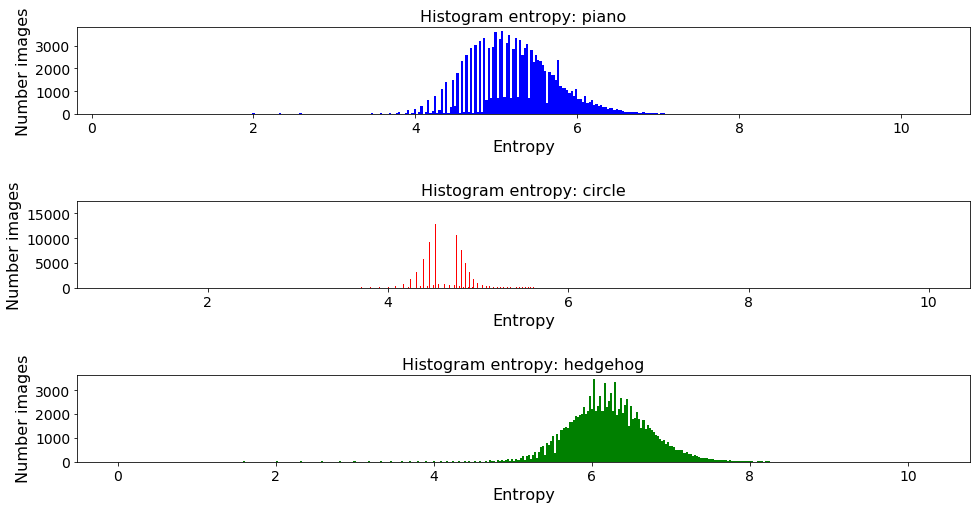

<Figure size 432x288 with 0 Axes>

In [29]:
plt.figure("Entropy distribution",figsize=(16,8))
plt.subplots_adjust(hspace=1.0)

plt.subplot(3,1,1)
plt.title("Histogram entropy: "+ label,fontsize=16)
plt.hist(entropy_label, bins='auto',color="blue")
plt.xlabel('Entropy',fontsize=16)
plt.ylabel("Number images",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(3,1,2)
plt.title("Histogram entropy: "+ label2,fontsize=16)
plt.hist(entropy_label2, bins='auto',color='red')
plt.xlabel('Entropy',fontsize=16)
plt.ylabel("Number images",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(3,1,3)
plt.title("Histogram entropy: "+ label3,fontsize=16)
plt.hist(entropy_label3, bins='auto',color='green')
plt.xlabel('Entropy',fontsize=16)
plt.ylabel("Number images",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
plt.savefig('plot_2.png')
